In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../"))

['proc', 'run', 'var', 'lib', 'tmp', 'mnt', 'root', 'opt', 'boot', 'bin', 'home', 'usr', 'media', 'lib64', 'etc', 'srv', 'dev', 'sys', 'sbin', 'train.csv', 'test.csv', '.dockerenv', 'tools', 'datalab', 'swift', 'tensorflow-1.15.2', 'content', 'dlib-19.18.0-cp36-cp36m-linux_x86_64.whl', 'dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl', 'lib32']


In [4]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io

df_train = pd.read_csv('../train.csv')
df_test = pd.read_csv('../test.csv')
df = pd.concat([df_train, df_test])
df = df[df['target'] == 1]
print(df.shape)
df.head()

(3271, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


## inspect text

In [0]:
# lowercase all
text = df['text'].str.lower()

we probably want to keep the hashtags, but if there are for example random characters (like links), we want to drop them so they won't affct the precictions

In [6]:
np.random.seed(12345)
np.random.choice(text,10)

array(['dog rendered a kitten from burning buildings\nhttps://t.co/9cpwiecegv http://t.co/rzlytnez2u',
       'wackos like #michelebachman predict the world will soon be obliterated by a burning firey inferno but cant accept #globalwarming!! hello!!!',
       'two giant cranes holding a bridge collapse into nearby homes http://t.co/umanaahwmi',
       "@reriellechan he was the lich king's first casualty block me back i hate you! http://t.co/0gidg9u45j",
       '@swiftycommissh @taoistinsight @immortaltech some jewish ppl agree tht israel is a bully nd a terrorist state killin palestine kids nd women',
       '@icymagistrate \x89ûóher upper arm\x89ûò those /friggin/ icicle projectiles\x89ûò and leg from various other wounds the girl looks like a miniature more\x89ûó',
       '#?? #?? #??? #??? suicide bomber kills 15 in saudi security site mosque - reuters  http://t.co/txg7k2do9v',
       '70 years ago today 1945 #hiroshima was the first nuclear atomic bomb leaving a major disaster in t

In [7]:
print('BEFORE:')
print(text[100])
text = text.map(lambda s: ' '.join([x for x in s.split() if 'http' not in x]))
print('AFTER:')
print(text[100])

BEFORE:
.@norwaymfa #bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gfjfgtodad
AFTER:
.@norwaymfa #bahrain police had previously died in a road accident they were not killed by explosion


any super short tweets?

max tweet len: 151
min tweet len: 8
AxesSubplot(0.125,0.125;0.775x0.755)


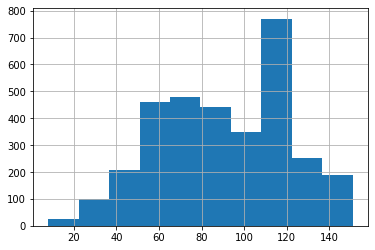

In [8]:
print('max tweet len:',text.map(len).max())
print('min tweet len:',text.map(len).min())
print(text.map(len).hist())

In [9]:
text = text[text.map(len)>60]
len(text)

2663

## Get Chars Dictionary

In [10]:
chars = sorted(list(set(''.join(text))))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 89


Inspect Chars

In [11]:
print(chars)

[' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', '[', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x89', '\x9d', '¡', '¢', '£', '¤', '¨', '©', 'ª', '¬', '¼', 'â', 'å', 'è', 'ê', 'ì', 'ï', 'ñ', 'ò', 'ó', '÷', 'û', 'ü']


maybe last ones are emojis?
Let's take a look at sentences with the weird chars.

In [12]:
for c in chars[-27:]:
    print('\nCHAR:', c)
    smple = [x for x in text if c in x]
    print(random.sample(smple,min(3,len(smple))))


CHAR: {
['{:en}tension in bayelsa as patience jonathan plans to hijack apcåêpdp{:}']

CHAR: |
['#nursing alert: emergency department psychiatric rn (.90 fte day) | providence health &amp; services | #olympia wa', 'discovered plane debris is from missing malaysia airlines flight 370 | time', 'the guardian view on the hiroshima legacy: still in the shadow of the bomb | editorial: the world longs to cas...']

CHAR: }
['{:en}tension in bayelsa as patience jonathan plans to hijack apcåêpdp{:}']

CHAR: ~
['severe t-storm warning for union county ~3:45pm. top threats include heavy rain lightning &amp; damaging winds.', 'some of the aftershocks can be just as big as the initial earthquake.~', 'hurricane guillermo live noaa tracking / looping wed.aug.5th ~ ~']

CHAR: 
['top stories - google 4 dead dozens injured in gaza blast near house leveled in summer war\x89û_', 'police officer wounded suspect dead after exchanging shots: richmond va. (ap) \x89ûó a richmond police officer wa...', '#bestna

still weird....
let's remove them

In [0]:
import re
for c in chars[-27:]:
    text = text.str.replace(c,'')

In [14]:
chars = sorted(list(set(''.join(text))))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(chars)

total chars: 62
[' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', '[', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Create Input Data
<br>
input - 40 characters of a tweet
<br>
output - next character

In [15]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 1
sentences = []
next_chars = []
for x in text:
    for i in range(0, len(x) - maxlen, step):
        sentences.append(x[i: i + maxlen])
        next_chars.append(x[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 159172


In [16]:
## check example
for i in range(3):
    print(sentences[i],'==>',next_chars[i])

our deeds are the reason of this #earthq ==> u
ur deeds are the reason of this #earthqu ==> a
r deeds are the reason of this #earthqua ==> k


In [17]:
text[0]

'our deeds are the reason of this #earthquake may allah forgive us all'

## Vectorization
1. Turn X into matrix of (numer_of_sentences,max_len_of_sentence,num_chars).
<br>
If char i is number j char in sentence k, there will be a 1 in location (k,j,i)
<br>
2. Turn y into a vector of (number_of_sentences,num_chars).
<br>
If character z is the next character in sentence k, there will be a 1 in locaiton (k,z)

In [18]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


## build the model: a single LSTM

1. Define we have a sequential model
2. Add an LSTM layer with 128 units. Input shape is a matrix of maxlen characters, where each character is a vector of len(chars)
3. Add a dense layer (fully connected layer) and have the softmax activation pick a winner from the len(chars) possible characters.
4. Pick an optimizer for the network and choose categorical_crossentropy loss function (used in multiclass classification).

In [19]:
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

# optimizer = RMSprop(lr=0.01)
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


## Sampler
We don't want the next character to be the one with the highest probaility (we'll get the same results every time).
So we sample with temperature parameter

In [0]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

example of what the function does:

In [21]:
for temperature in [0.1, 0.2, 0.3,  0.5, 1.0, 1.2, 1.3]:
    print(sample([.1,.3,.5,.1],temperature=temperature))

2
2
2
2
1
0
1


We gave the function an array where highest probability was index number 2 (.5).
When temperature was low, we got what we expected.
As we increased the temperature, the function got more creative license choosing the max.
So:
1. temperature helps us not get the same text generated every time
2. low temperature = text similar to trained data
3. high temperature = more creative generation
4. too high temperature = nonsense.

## Generate Text at Epoch End

In [0]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    
#     start_index = random.randint(0, len(text) - maxlen - 1)
    tweet = np.random.choice(text) # select random tweet
    start_index = 0

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = tweet[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

#     generate 120 characters
        for i in range(120):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [23]:
epochs = 5

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y,
          batch_size=128,
          epochs=epochs,
          callbacks=[print_callback])

Epoch 1/5
159172/159172 [==============================] - 71s 449us/step - loss: 2.7702

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "@random_tourist it rained. some guys tre"
@random_tourist it rained. some guys tre the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
----- diversity: 0.5
----- Generating with seed: "@random_tourist it rained. some guys tre"
@random_tourist it rained. some guys tre the. for than sin thes math salcte de on baline be carass ond an patho pat sing math an wall rain - bract on she the t 
----- diversity: 1.0
----- Generating with seed: "@random_tourist it rained. some guys tre"
@random_tourist it rained. some guys tremarmaid'.-0: mn #ary restidle arfuf. sion dit in bule ce lilkin lics net y nbend mals iicsl.. pounger #o#waldeon (on the
----- diversity: 1.2
----- Generating with seed: "@random_tourist it rained. some guys tre"
@random_tourist it rai

In [24]:
print('Build model...')
model2 = Sequential()
model2.add(LSTM(128, input_shape=(maxlen, len(chars)),return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(128))
model2.add(Dropout(0.2))
model2.add(Dense(len(chars), activation='softmax'))

# optimizer = RMSprop(lr=0.01)
optimizer = Adam()
model2.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


In [25]:
epochs = 60

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model2.fit(x, y,
          batch_size=128,
          epochs=epochs,
          callbacks=[print_callback])

Epoch 1/60
159172/159172 [==============================] - 137s 860us/step - loss: 2.7972

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "usgs reports a m1.94 #earthquake 5km s o"
usgs reports a m1.94 #earthquake 5km s of the store the the the the prot the the the polled in the the prost the plope the storm in the the seart of the and the
----- diversity: 0.5
----- Generating with seed: "usgs reports a m1.94 #earthquake 5km s o"
usgs reports a m1.94 #earthquake 5km s ot goather the mat the propple sout to hor a called the seard of the har hat love the werl the than peaple proced honts w
----- diversity: 1.0
----- Generating with seed: "usgs reports a m1.94 #earthquake 5km s o"
usgs reports a m1.94 #earthquake 5km s ole cap fol coplupte dow ats antrailds: spicier wy hetrers belony hors treaghith at nut to the perts blop seave and vig p
----- diversity: 1.2
----- Generating with seed: "usgs reports a m1.94 #earthquake 5km s o"
usgs reports a m1.94

In [0]:
model2.save('model_0.h5')

In [27]:
for diversity in [0.2, 0.5, 1.0, 1.2]:
#     start_index = random.randint(0, len(text) - maxlen - 1)
    with open('model_0_output_with_{}_diversity.txt'.format(diversity), 'a') as f:
        start_index = 0
        f.write('----- diversity:{}\n'.format(diversity))
        for tweet in text:
            generated = ''
            sentence = tweet[start_index: start_index + maxlen]
            generated += sentence
            f.write('----- Generating with seed: "' + sentence + '"\n')
#             f.write(generated)

            for i in range(120):
                x_pred = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.

                preds = model2.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]

                generated += next_char
                sentence = sentence[1:] + next_char

#                 sys.stdout.write(next_char)
#                 sys.stdout.flush()
            f.write(generated + '\n')
            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
